In [1]:
# only for macbook with AMD GPU
import os
import plaidml.keras
plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')


In [3]:
data = pd.read_csv('./../New Folder With Items/MIT_BIH_DATASET_Resampled_Filltered_6_2021.csv')

In [4]:
data_new = data.to_numpy()
print(data_new.shape)

(27200, 301)


In [5]:
data, labels = data_new[:, :-1], data_new[:, -1]
print(data.shape, labels.shape)

(27200, 300) (27200,)


In [6]:
from biosppy.signals import ecg
from scipy import signal


In [7]:
from sklearn.utils import class_weight


In [8]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labels),
                                                 labels)

In [9]:
def scale_data(data, lower=0, upper=1024):
    '''scales passed sequence between thresholds

    Function that scales passed data so that it has specified lower 
    and upper bounds.
    
    Parameters
    ----------
    data : 1-d array or list
        Sequence to be scaled

    lower : int or float
        lower threshold for scaling
        default : 0

    upper : int or float
        upper threshold for scaling
        default : 1024

    Returns
    -------
    out : 1-d array
        contains scaled data

    Examples
    --------
    When passing data without further arguments to the function means it scales 0-1024
    
    >>> x = [2, 3, 4, 5]
    >>> scale_data(x)
    array([   0.        ,  341.33333333,  682.66666667, 1024.        ])

    Or you can specify a range:

    >>> scale_data(x, lower = 50, upper = 124)
    array([ 50.        ,  74.66666667,  99.33333333, 124.        ])
    '''

    rng = np.max(data) - np.min(data)
    minimum = np.min(data)
    data = (upper - lower) * ((data - minimum) / rng) + lower
    return data

In [10]:
sampling_rate = float(300)
# filter signal
order = int(0.3 * sampling_rate)
filter_data = np.zeros((len(data),len(data[0])))
for i, (xrow, yrow) in enumerate(zip(data, labels)):
  filtered, _, _ = ecg.st.filter_signal(signal=xrow,
                                      ftype='FIR',
                                      band='bandpass',
                                      order=order,
                                      frequency=[3, 45],
                                      sampling_rate=sampling_rate)
    
  # print(filtered)
  scaled = scale_data(filtered,lower=0, upper=1)
  filter_data[i] = scaled

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(filter_data, labels, test_size=0.40, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.50, random_state=42)

In [46]:
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_valid = X_valid.reshape(len(X_valid), X_valid.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [47]:
del model

In [48]:
def network(X_train,y_train,X_test,y_test,batch_size=32,epochs=10):
    im_shape=(X_train.shape[1],1)
    model = Sequential()
#     model.add(Input(shape=(im_shape), name='inputs_cnn'))
    model.add(Convolution1D(64, (6), activation='relu', input_shape=im_shape))
    model.add(BatchNormalization())    
    model.add(MaxPool1D(pool_size=(3), strides=(2), padding="same"))    
    model.add(Convolution1D(64, (3), activation='relu', input_shape=im_shape))    
    model.add(BatchNormalization())    
    model.add(MaxPool1D(pool_size=(2), strides=(2), padding="same"))
    model.add(Convolution1D(64, (3), activation='relu', input_shape=im_shape))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=(2), strides=(2), padding="same"))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(5, activation='softmax', name='main_output'))
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    mincp_save =keras.callbacks.ModelCheckpoint('./CNN1DbestEpochMin.hdf5', save_best_only=True, monitor='val_loss', mode='min')
    maxcp_save =keras.callbacks.ModelCheckpoint('./CNN1DbestEpochMax.hdf5', save_best_only=True, monitor='val_acc', mode='max')
    callbacks = [mincp_save,maxcp_save]
    model.summary()
    import tensorflow as tf

    tf.keras.utils.plot_model(
        model
    )

    history=model.fit(X_train, y_train,epochs=epochs,callbacks=callbacks,class_weight=class_weights, batch_size=batch_size,validation_data=(X_test,y_test))
    return(model,history)

In [49]:
X_train_ = np.expand_dims(X_train, axis=1)
X_valid_ = np.expand_dims(X_valid, axis=1)
    

In [50]:
y_train_ = to_categorical(y_train)
y_valid_ = to_categorical(y_valid)

In [51]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model,Sequential
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [52]:

model,history=network(X_train,y_train_,X_valid,y_valid_,batch_size=32,epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 295, 64)           448       
_________________________________________________________________
batch_normalization_16 (Batc (None, 295, 64)           256       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 148, 64)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 146, 64)           12352     
_________________________________________________________________
batch_normalization_17 (Batc (None, 146, 64)           256       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 73, 64)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 71, 64)            12352     
__________

In [18]:
from keras.models import load_model


In [39]:
del modelCNN1DbestEpochMin.hdf5

In [40]:
model = load_model('model_cnn1d_scaled_sequential.h5')

In [58]:
model.load_weights('./CNN1DbestEpochMin.hdf5')

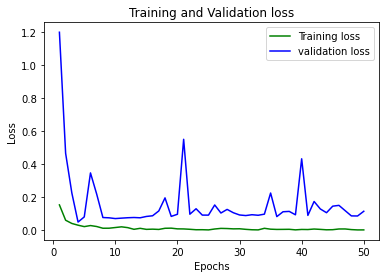

In [54]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

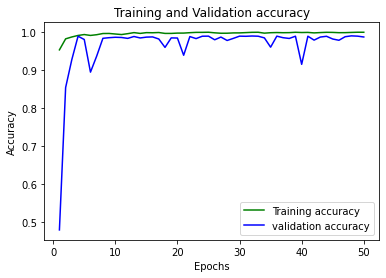

In [55]:
loss_train = history.history['acc']
loss_val = history.history['val_acc']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [65]:
min(history.history['val_loss'])

0.04775929571512867

In [57]:
model.save('model_cnn1d_scaled_final_sequential.h5')

AttributeError: 'Sequential' object has no attribute 'save_model'

In [31]:
min(history.history['val_loss'])

0.051695096405113446

In [32]:
X_test_ = np.expand_dims(X_test, axis=1)

In [33]:
X_test_[0:3].shape

(3, 1, 300, 1)

In [34]:
y_valid_ = to_categorical(y_test)

In [43]:
model.load_weights('./CNN1DbestEpochMin.hdf5')

In [146]:
results = model.predict_classes(X_test[0:3])


In [148]:
y_test[0:3]

array([0., 2., 1.])

In [147]:
results


array([0, 2, 1])

In [ ]:
X_train,y_train_,X_valid,y_valid_

In [36]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_train, y_train_)
print("test loss, test acc:", results)

Evaluate on test data
16320/16320 [==============================] - 1s 87us/step
test loss, test acc: [0.002623510850118656, 0.9990808823529411]


In [35]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_valid_)
print("test loss, test acc:", results)

Evaluate on test data
5440/5440 [==============================] - 1s 104us/step
test loss, test acc: [0.08446603505050435, 0.9878676470588236]


In [79]:
!pip3 freeze

appnope==0.1.2
asgiref==3.2.10
astroid==2.4.2
astunparse==1.6.3
async-generator==1.10
attrs==20.3.0
autopep8==1.5.6
backcall==0.2.0
beautifulsoup4==4.9.3
bidict==0.21.2
biosignalsnotebooks==0.6.5
biosppy==0.7.0
bleach==3.3.0
bokeh==2.3.1
cached-property==1.5.2
certifi==2020.6.20
chardet==3.0.4
click==7.1.2
cycler==0.10.0
DateTime==4.3
decorator==5.0.7
defusedxml==0.6.0
diff-match-patch==20200713
Django==3.0.7
django-admin-interface==0.12.3
django-allauth==0.42.0
django-ckeditor==6.0.0
django-colorfield==0.3.2
django-cors-headers==3.4.0
django-crispy-forms==1.9.1
django-environ==0.4.5
django-flat-responsive==2.0
django-flat-theme==1.1.4
django-import-export==2.3.0
django-js-asset==1.2.2
django-markdown==0.8.4
django-modeltranslation==0.15.1
django-tinymce==3.3.0
djangorestframework==3.11.0
dukpy==0.2.3
entrypoints==0.3
et-xmlfile==1.0.1
filelock==3.0.12
gdown==3.13.0
gunicorn==20.0.4
h5py==3.2.1
idna==2.10
importlib-metadata==3.7.0
ipython==7.22.0
ipython-genutils==0.2.0
isort==4.3.21
j